# FET445 – Veri Madenciliği  
## Bu syafada : 
## 1:  Wisam AlMohamed – Temel Model Geliştirme (Base Modeller + Özellik Seçimi + Boyut İndirgeme + Multi‑Stage Classification System (Stage 0 → Stage 2)

## 2: Wisamın yazdiği Multi‑Stage Classification System (Stage 0 → Stage 2 ILE Mustafanını yazdığı  Multi‑Stage Classification System (Stage 0 → Stage 2 karşılanması 

This section implements the required multi‑stage system:

Stage 0: Preprocessing + SMOTETomek
Stage 1: Logistic Regression (balanced) + Random Forest
Stage 2: XGBoost (XGBClassifier))

Bu notebook, **Depression Dataset** üzerinde çalışarak:
- Ortak veri keşfi (EDA) ve ön işleme adımlarını,
- Wisam'ın sorumlu olduğu **özellik seçimi (Feature Selection)** tekniklerini,
- **Boyut indirgeme (Dimensionality Reduction)** adımlarını,
- Ve bunların farklı **temel (base) modeller üzerindeki etkisini** göstermektedir.

Hedef değişken (**target**): `History of Mental Illness`  
Görev türü: **İkili sınıflandırma (binary classification)**.


## 1. Problem Tanımı

Bu projede amaç, bireylerin yaşam tarzı, demografik özellikleri ve sağlık durumları gibi
değişkenleri kullanarak, geçmişte herhangi bir psikolojik rahatsızlık yaşayıp yaşamadıklarını
tahmin etmektir.

Bu notebook'ta Wisam'ın katkısı:
- Ortak veri ön işleme pipeline'ının kullanılması,
- Farklı **özellik seçimi** tekniklerinin denenmesi:
  - `SelectKBest(chi2)`
  - `SelectKBest(mutual_info_classif)`
- `PCA` ile boyut indirgeme,
- İki temel modelin kullanılması:
  - Lojistik Regresyon (`LogisticRegression`)
  - Karar Ağacı (`DecisionTreeClassifier`),
- Ve tüm aşamalar için **performans karşılaştırması** yapılmasıdır.


## 2. Kurulum ve Gerekli Kütüphaneler

Bu bölümde veri işleme, modelleme ve değerlendirme için gerekli Python kütüphaneleri yüklenmektedir.


In [1]:
!pip install imbalanced-learn

In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)


## 3. Veri Setini Yükleme

Bu projede Kaggle üzerinde yer alan **Depression Dataset** kullanılmaktadır.  
Lütfen aynı klasörde veri dosyasının adını uygun şekilde ayarlayın.

- Önerilen dosya adı: `depression_data.csv` veya `depression-dataset.csv`
- Hedef sütun: `History of Mental Illness`


In [4]:
CSV_PATH = "depression_data.csv"  # Gerekirse dosya adını değiştir
TARGET_COL = "History of Mental Illness"

# Veriyi oku
df = pd.read_csv(CSV_PATH)

# Hedef sütunu 0/1'e çeviriyoruz: No -> 0, Yes -> 1
df[TARGET_COL] = df[TARGET_COL].map({"No": 0, "Yes": 1})

print("Veri şekli (satır, sütun):", df.shape)
df.head()



Veri şekli (satır, sütun): (413768, 16)


,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,1,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,1,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,0,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,0,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,1,No,Yes,Yes


## 4. Veri Setinin Genel Özeti

Bu bölümde veri setinin temel yapısı incelenmektedir:
- Sütun isimleri ve veri tipleri
- Sayısal ve kategorik sütunların ayrımı


In [5]:
# Sütun bilgileri
print("Sütun tipleri:\n")
print(df.dtypes)

print("\nİlk 5 gözlem:")
df.head()


Sütun tipleri:

Name                             object
Age                               int64
Marital Status                   object
Education Level                  object
Number of Children                int64
Smoking Status                   object
Physical Activity Level          object
Employment Status                object
Income                          float64
Alcohol Consumption              object
Dietary Habits                   object
Sleep Patterns                   object
History of Mental Illness         int64
History of Substance Abuse       object
Family History of Depression     object
Chronic Medical Conditions       object
dtype: object

İlk 5 gözlem:


,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,1,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,1,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,0,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,0,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,1,No,Yes,Yes


## 5. Eksik Değer Analizi ve Hedef Değişkenin Dağılımı

Modelleme öncesi:
- Hangi sütunlarda eksik veri var?
- Hedef sınıflar dengeli mi, dengesiz mi?


Eksik değer sayıları:

Name                            0
Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64

Hedef değişken dağılımı (adet):
History of Mental Illness
0    287943
1    125825
Name: count, dtype: int64

Hedef değişken dağılımı (oran):
History of Mental Illness
0    0.695904
1    0.304096
Name: proportion, dtype: float64


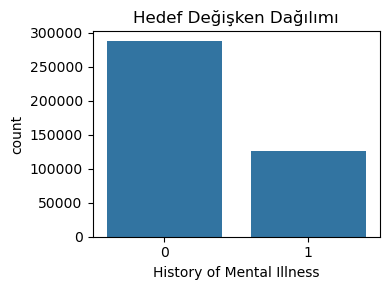

In [6]:
# Eksik değer sayıları
print("Eksik değer sayıları:\n")
print(df.isna().sum())

# Hedef değişken dağılımı
print("\nHedef değişken dağılımı (adet):")
print(df[TARGET_COL].value_counts())

print("\nHedef değişken dağılımı (oran):")
print(df[TARGET_COL].value_counts(normalize=True))

# İsteğe bağlı görselleştirme
plt.figure(figsize=(4,3))
sns.countplot(x=TARGET_COL, data=df)
plt.title("Hedef Değişken Dağılımı")
plt.tight_layout()
plt.show()


## 6. Özellik Türlerini Belirleme (Sayısal vs. Kategorik)

Makine öğrenmesi modelleri için sayısal ve kategorik sütunlara farklı ön işleme
adımları uygulanacaktır.

- Sayısal sütunlar: Ölçeklendirme (scaling)
- Kategorik sütunlar: One-Hot Encoding


In [7]:
# Özellik ve hedef ayrımı
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Sayısal ve kategorik sütunları otomatik bul
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Sayısal sütunlar:", num_cols)
print("Kategorik sütunlar:", cat_cols)



Sayısal sütunlar: ['Age', 'Number of Children', 'Income']
Kategorik sütunlar: ['Name', 'Marital Status', 'Education Level', 'Smoking Status', 'Physical Activity Level', 'Employment Status', 'Alcohol Consumption', 'Dietary Habits', 'Sleep Patterns', 'History of Substance Abuse', 'Family History of Depression', 'Chronic Medical Conditions']


## 7. Ortak Ön İşleme Adımları (Preprocessing Pipeline)

Bu pipeline **tüm modeller** için ortaktır ve şu adımlardan oluşur:

- Sayısal sütunlar için:
  - Eksik değer doldurma (median)
  - Min-Max ölçeklendirme (0–1 aralığı)
- Kategorik sütunlar için:
  - Eksik değer doldurma (en sık görülen)
  - One-Hot Encoding


In [8]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


## 8. Eğitim ve Test Kümesine Ayırma

Veri seti eğitim (train) ve test olarak ikiye ayrılacaktır.

- Test oranı: %20  
- Stratify: Hedef değişkenin sınıf dağılımını korumak için kullanılır.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Eğitim kümesi boyutu:", X_train.shape)
print("Test kümesi boyutu:", X_test.shape)


Eğitim kümesi boyutu: (331014, 15)
Test kümesi boyutu: (82754, 15)


## 9. Değerlendirme Fonksiyonu

Tüm modeller için aynı değerlendirme fonksiyonu kullanılacaktır.

Hesaplanan metrikler:
- Doğruluk (Accuracy)
- F1 skoru
- ROC AUC (model olasılık tahmini veriyorsa)
- Sınıflandırma raporu ve karışıklık matrisi


In [10]:
def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test):
    # Verilen pipeline'ı eğitir ve temel sınıflandırma metriklerini hesaplar.
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Bazı modeller predict_proba desteklemeyebilir
    auc = None
    if hasattr(pipeline, "predict_proba"):
        try:
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
        except Exception:
            auc = None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    if auc is not None:
        print("ROC AUC:", auc)
    print("\nSınıflandırma Raporu:")
    print(classification_report(y_test, y_pred))

    # Karışıklık matrisi
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.tight_layout()
    plt.show()

    return {
        "name": name,
        "accuracy": acc,
        "f1": f1,
        "auc": auc
    }


## 10. Baz Modeller (Özellik Seçimi ve Boyut İndirgeme OLMADAN)

Bu bölümde ortak ön işleme adımlarını kullanarak, aşağıdaki iki temel model eğitilir:

- Lojistik Regresyon (`LogisticRegression`)
- Karar Ağacı (`DecisionTreeClassifier`)

Bu sonuçlar, daha sonra **özellik seçimi** ve **boyut indirgeme** sonrası elde edilen performans
ile karşılaştırılacaktır.


=== Baz Model - Logistic Regression ===
Accuracy: 0.6838823500978805
F1 Score: 0.09985548138462597
ROC AUC: 0.5695182146338222

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      0.96      0.81     57589
           1       0.37      0.06      0.10     25165

    accuracy                           0.68     82754
   macro avg       0.54      0.51      0.45     82754
weighted avg       0.60      0.68      0.59     82754



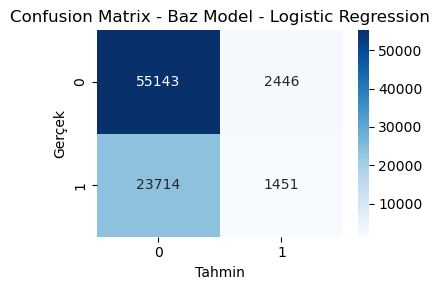

=== Baz Model - Decision Tree ===
Accuracy: 0.6385914880247481
F1 Score: 0.2787691714092794
ROC AUC: 0.5234791086257466

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.71      0.82      0.76     57589
           1       0.35      0.23      0.28     25165

    accuracy                           0.64     82754
   macro avg       0.53      0.52      0.52     82754
weighted avg       0.60      0.64      0.61     82754



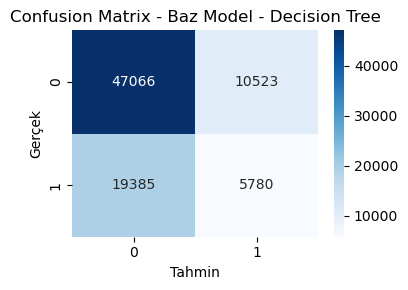

In [9]:
baseline_results = []

# 1) Logistic Regression (baseline)
log_reg = LogisticRegression(max_iter=1000)

baseline_lr_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_reg)
])

res_baseline_lr = evaluate_model(
    "Baz Model - Logistic Regression",
    baseline_lr_pipeline,
    X_train, y_train,
    X_test, y_test
)
baseline_results.append(res_baseline_lr)

# 2) Decision Tree (baseline)
dt_clf = DecisionTreeClassifier(random_state=42)

baseline_dt_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", dt_clf)
])

res_baseline_dt = evaluate_model(
    "Baz Model - Decision Tree",
    baseline_dt_pipeline,
    X_train, y_train,
    X_test, y_test
)
baseline_results.append(res_baseline_dt)


## 11. Wisam – Özellik Seçimi (SelectKBest – Chi2)

Bu bölümde Wisam'ın sorumlu olduğu ilk özellik seçimi tekniği uygulanmaktadır:

- **Yöntem:** `SelectKBest(score_func=chi2)`  
- Amaç: Hedef değişken ile en güçlü ilişkiye sahip özellikleri seçmek  
- Not: Chi2, 0'dan büyük sayısal değerler ve one-hot kodlanmış kategorik verilerle iyi çalışır.

Seçilen özellikler ile tekrar:
- Logistic Regression
- Decision Tree

modelleri eğitilecek ve sonuçlar baz model ile karşılaştırılacaktır.


=== Wisam - Logistic Regression + Chi2(SelectKBest) ===
Accuracy: 0.6959059380815429
F1 Score: 0.0
ROC AUC: 0.59187347013505

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     57589
           1       0.00      0.00      0.00     25165

    accuracy                           0.70     82754
   macro avg       0.35      0.50      0.41     82754
weighted avg       0.48      0.70      0.57     82754



C:\Users\Wisam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Wisam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Wisam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


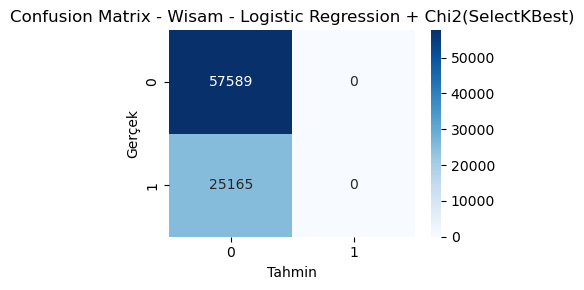

=== Wisam - Decision Tree + Chi2(SelectKBest) ===
Accuracy: 0.5832346472678058
F1 Score: 0.32553045859000684
ROC AUC: 0.5121535437523552

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70     57589
           1       0.32      0.33      0.33     25165

    accuracy                           0.58     82754
   macro avg       0.51      0.51      0.51     82754
weighted avg       0.59      0.58      0.59     82754



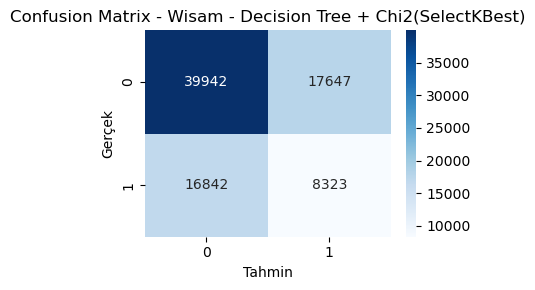

In [12]:
fs_results = []  # Wisam'a ait tüm FS/DR sonuçları burada toplanacak

k_best = 15  # Seçilecek özellik sayısı (gerekirse ayarlanabilir)

chi2_selector = SelectKBest(score_func=chi2, k=k_best)

# 1) Logistic Regression + Chi2
lr_chi2_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("chi2", chi2_selector),
    ("model", LogisticRegression(max_iter=1000))
])

res_lr_chi2 = evaluate_model(
    "Wisam - Logistic Regression + Chi2(SelectKBest)",
    lr_chi2_pipeline,
    X_train, y_train,
    X_test, y_test
)
fs_results.append(res_lr_chi2)

# 2) Decision Tree + Chi2
dt_chi2_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("chi2", chi2_selector),
    ("model", DecisionTreeClassifier(random_state=42))
])

res_dt_chi2 = evaluate_model(
    "Wisam - Decision Tree + Chi2(SelectKBest)",
    dt_chi2_pipeline,
    X_train, y_train,
    X_test, y_test
)
fs_results.append(res_dt_chi2)


## 12. Wisam – Özellik Seçimi (Mutual Information) + Boyut İndirgeme (PCA)

Bu bölümde ikinci özellik seçimi tekniği ve boyut indirgeme birlikte kullanılmaktadır:

- **Özellik Seçimi:** `SelectKBest(score_func=mutual_info_classif)`
- **Boyut İndirgeme:** `PCA`

Amaç:
- Önce hedefle bilgi kazancı yüksek özellikleri seçmek,
- Ardından PCA ile boyutu küçülterek gürültüyü azaltmak,
- Aynı iki modeli (LR ve DT) bu yeni temsil üzerinde tekrar eğitmek.


MI + PCA örneklem üzerinde çalıştırılıyor...


C:\Users\Wisam\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Wisam\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Wisam\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


=== Wisam - Logistic Regression + MI + PCA (Sample) ===
Accuracy: 0.6959059380815429
F1 Score: 0.0
ROC AUC: 0.5917462837270748

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     57589
           1       0.00      0.00      0.00     25165

    accuracy                           0.70     82754
   macro avg       0.35      0.50      0.41     82754
weighted avg       0.48      0.70      0.57     82754



C:\Users\Wisam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Wisam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Wisam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


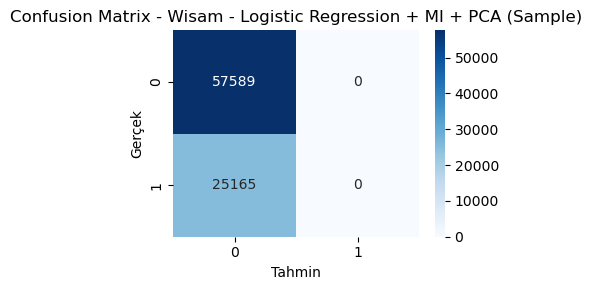

MI + PCA başarıyla tamamlandı.


In [13]:
# ===============================================
# MI + PCA (Örneklem Üzerinde) – Wisam
# ===============================================

print("MI + PCA örneklem üzerinde çalıştırılıyor...")

# 1) Örneklem alma (Bilgisayar kaynakları için zorunlu)
sample_size = 50000  # gerekirse 30k yapabiliriz
X_train_sample = X_train.sample(sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# 2) MI (Mutual Information)
k_best_mi = 10  

def mi_score(X, y):
    return mutual_info_classif(
        X, y,
        discrete_features='auto',
        n_neighbors=3,
        copy=True,
        random_state=42,
        n_jobs=1
    )

mi_selector = SelectKBest(score_func=mi_score, k=k_best_mi)

# 3) PCA
n_pca_components = 8
pca = PCA(n_components=n_pca_components)

# 4) Logistic Regression + MI + PCA (örneklem üzerinde)
lr_mi_pca_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("mi", mi_selector),
    ("pca", pca),
    ("model", LogisticRegression(max_iter=1000))
])

res_lr_mi_pca = evaluate_model(
    "Wisam - Logistic Regression + MI + PCA (Sample)",
    lr_mi_pca_pipeline,
    X_train_sample, y_train_sample,
    X_test, y_test
)

fs_results.append(res_lr_mi_pca)

print("MI + PCA başarıyla tamamlandı.")

## 13. Sonuçların Karşılaştırılması ve Özet Tablo

Aşağıdaki tabloda:
- Baz modeller
- Chi2 ile özellik seçimi
- Mutual Information + PCA

sonrasında elde edilen metrikler yan yana gösterilmekte ve Wisam'ın katkısı özetlenmektedir.


In [14]:
# Sonuçları DataFrame olarak birleştirelim
import pandas as pd

all_results = []

for r in baseline_results:
    r2 = r.copy()
    r2["kategori"] = "Baz Model"
    all_results.append(r2)

for r in fs_results:
    r2 = r.copy()
    r2["kategori"] = "Wisam - FS/DR"
    all_results.append(r2)

results_df = pd.DataFrame(all_results)
results_df


,name,accuracy,f1,auc,kategori
0,Baz Model - Logistic Regression,0.683882,0.099855,0.569518,Baz Model
1,Baz Model - Decision Tree,0.638591,0.278769,0.523479,Baz Model
2,Wisam - Logistic Regression + Chi2(SelectKBest),0.695906,0.000000,0.591873,Wisam - FS/DR
3,Wisam - Decision Tree + Chi2(SelectKBest),0.583235,0.325530,0.512154,Wisam - FS/DR
4,Wisam - Logistic Regression + MI + PCA (Sample),0.695906,0.000000,0.591746,Wisam - FS/DR



# Multi‑Stage Classification System (Stage 0 → Stage 2)

This section implements the required **multi‑stage system**:

- **Stage 0:** Preprocessing + SMOTETomek  
- **Stage 1:** Logistic Regression (balanced) + Random Forest  
- **Stage 2:** XGBoost (XGBClassifier)

The design follows a **stacked / ensemble‑style workflow** where Stage 1 models learn from balanced data,
and Stage 2 learns from their predictions.


In [11]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, recall_score

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier


In [12]:
print(df.columns.tolist())


['Name', 'Age', 'Marital Status', 'Education Level', 'Number of Children', 'Smoking Status', 'Physical Activity Level', 'Employment Status', 'Income', 'Alcohol Consumption', 'Dietary Habits', 'Sleep Patterns', 'History of Mental Illness', 'History of Substance Abuse', 'Family History of Depression', 'Chronic Medical Conditions']


In [13]:
# =========================
# Stage 0: Preprocessing + SMOTETomek
# =========================

# Split features and target
X = df.drop("History of Mental Illness", axis=1)
y = df["History of Mental Illness"]

# Select numeric features only
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns

# Preprocessing: scaling numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Handle class imbalance
smote_tomek = SMOTETomek(random_state=42)


In [14]:

# =========================
# Stage 1: Logistic (balanced) + Random Forest
# =========================

log_reg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced_subsample"
)

stage1_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote_tomek),
    ("logistic", log_reg)
])

stage1_pipeline.fit(X_train, y_train)

rf_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote_tomek),
    ("rf", rf)
])

rf_pipeline.fit(X_train, y_train)

# Stage 1 predictions
log_pred_train = stage1_pipeline.predict_proba(X_train)[:, 1]
rf_pred_train = rf_pipeline.predict_proba(X_train)[:, 1]

log_pred_test = stage1_pipeline.predict_proba(X_test)[:, 1]
rf_pred_test = rf_pipeline.predict_proba(X_test)[:, 1]


In [15]:

# =========================
# Stage 2: XGBoost (Meta‑Model)
# =========================

X_train_meta = np.column_stack([log_pred_train, rf_pred_train])
X_test_meta = np.column_stack([log_pred_test, rf_pred_test])

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train_meta, y_train)

y_pred = xgb.predict(X_test_meta)

print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


F1 Score: 0.36074578777795385
Recall: 0.4071130538446255
              precision    recall  f1-score   support

           0       0.71      0.63      0.67     57589
           1       0.32      0.41      0.36     25165

    accuracy                           0.56     82754
   macro avg       0.52      0.52      0.51     82754
weighted avg       0.59      0.56      0.57     82754



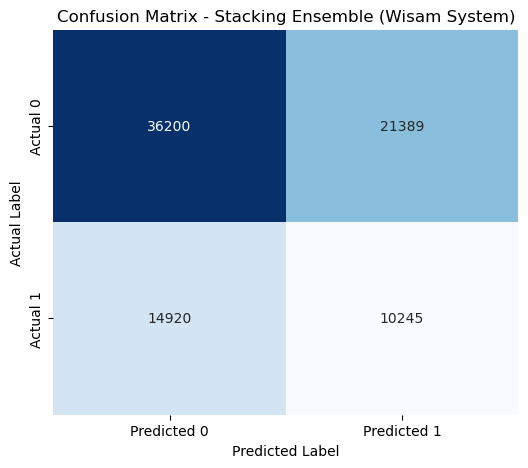

C:\Users\Wisam\AppData\Local\Temp\ipykernel_8048\3261173329.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray') # خط العشوائية


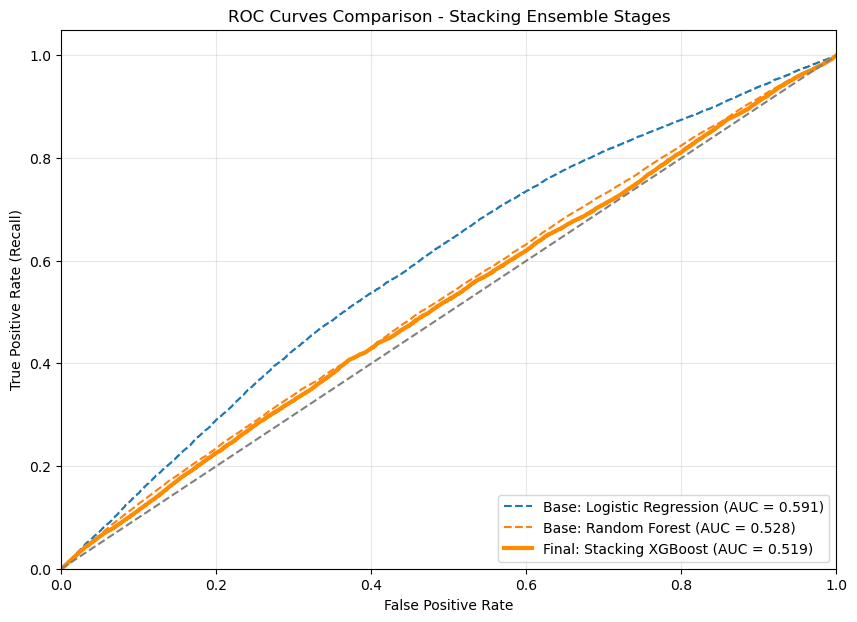

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ========================================================
# 1. تجهيز البيانات للرسم (حساب الاحتمالات للنموذج النهائي)
# ========================================================

# نحتاج احتمالات النموذج النهائي (XGBoost) لرسم ROC
# ملاحظة: log_pred_test و rf_pred_test تم حسابها مسبقاً في كودك وهي تمثل احتمالات المرحلة الأولى
y_proba_meta = xgb.predict_proba(X_test_meta)[:, 1]

# ========================================================
# 2. رسم مصفوفة الالتباس (Confusion Matrix)
# ========================================================

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)

# رسم المصفوفة باستخدام Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix - Stacking Ensemble (Wisam System)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ========================================================
# 3. رسم منحنيات ROC (مقارنة المراحل)
# ========================================================

plt.figure(figsize=(10, 7))

# --- منحنى النموذج الأساسي 1: Logistic Regression ---
fpr_log, tpr_log, _ = roc_curve(y_test, log_pred_test)
auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, linestyle='--', label=f'Base: Logistic Regression (AUC = {auc_log:.3f})')

# --- منحنى النموذج الأساسي 2: Random Forest ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_test)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, linestyle='--', label=f'Base: Random Forest (AUC = {auc_rf:.3f})')

# --- منحنى النموذج النهائي: Stacking XGBoost ---
fpr_meta, tpr_meta, _ = roc_curve(y_test, y_proba_meta)
auc_meta = auc(fpr_meta, tpr_meta)
plt.plot(fpr_meta, tpr_meta, linewidth=3, color='darkorange', label=f'Final: Stacking XGBoost (AUC = {auc_meta:.3f})')

# --- إعدادات الرسم ---
plt.plot([0, 1], [0, 1], 'k--', color='gray') # خط العشوائية
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves Comparison - Stacking Ensemble Stages')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

In [16]:
# =========================
# Threshold Scanning (Stage 2)
# =========================

y_proba = xgb.predict_proba(X_test_meta)[:, 1]

thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    results.append({
        "threshold": t,
        "recall": recall_score(y_test, y_pred_t),
        "precision": classification_report(y_test, y_pred_t, output_dict=True)["1"]["precision"],
        "f1": f1_score(y_test, y_pred_t)
    })

pd.DataFrame(results)


,threshold,recall,precision,f1
0,0.20,0.440930,0.319797,0.370719
1,0.25,0.433221,0.319192,0.367566
2,0.30,0.430598,0.319241,0.366651
3,0.35,0.420902,0.319643,0.363349
4,0.40,0.413471,0.321817,0.361932
5,0.45,0.408146,0.323547,0.360956
6,0.50,0.407113,0.323860,0.360746


In [17]:
# =========================
# Alternative Approach: Single Balanced XGBoost Model
# (No Stacking, No Threshold Tuning)
# =========================

# Calculate imbalance ratio
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

xgb_single = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)

single_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote_tomek),
    ("xgb", xgb_single)
])

# Fit the model
single_pipeline.fit(X_train, y_train)

# Prevent Jupyter from trying to render the pipeline
print("Single-model XGBoost pipeline fitted successfully.")


C:\Users\Wisam\anaconda3\envs\torch_env\lib\site-packages\xgboost\training.py:199: UserWarning: [11:18:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Single-model XGBoost pipeline fitted successfully.


In [18]:
# =========================
# Safe Evaluation (bypass ImbPipeline.predict issue)
# =========================

# Transform test data using the already-fitted preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Predict directly using the trained XGBoost model
y_pred_single = single_pipeline.named_steps["xgb"].predict(X_test_transformed)

print("Recall:", recall_score(y_test, y_pred_single))
print("F1 Score:", f1_score(y_test, y_pred_single))
print(classification_report(y_test, y_pred_single))


Recall: 0.9869660242400159
F1 Score: 0.467568407082145
              precision    recall  f1-score   support

           0       0.80      0.02      0.05     57589
           1       0.31      0.99      0.47     25165

    accuracy                           0.32     82754
   macro avg       0.56      0.51      0.26     82754
weighted avg       0.65      0.32      0.17     82754



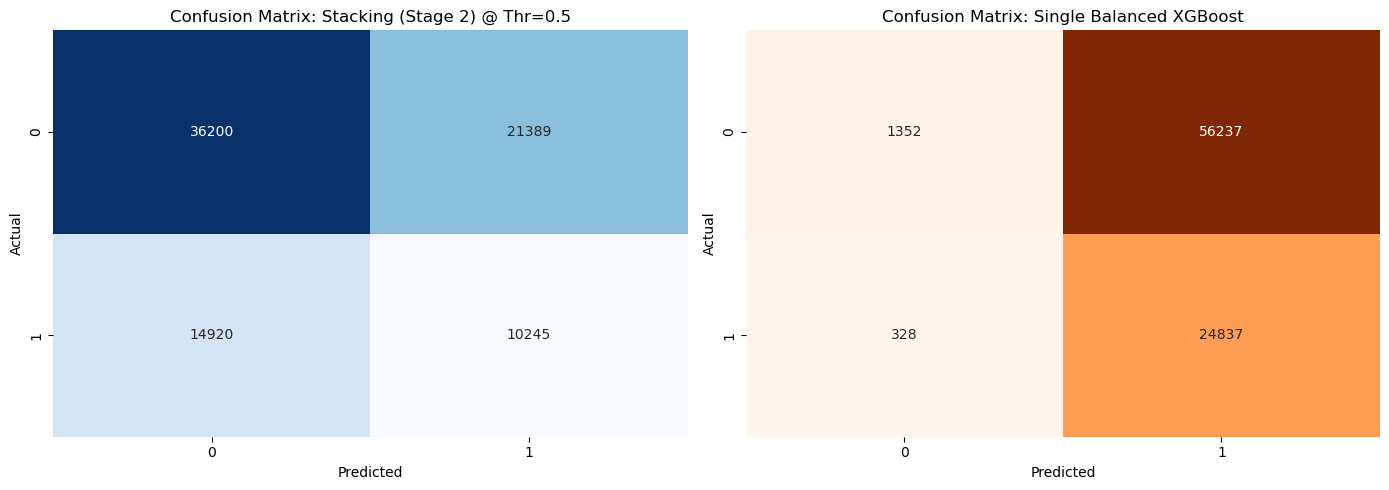

C:\Users\Wisam\AppData\Local\Temp\ipykernel_8048\2478483833.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray') # خط العشوائية


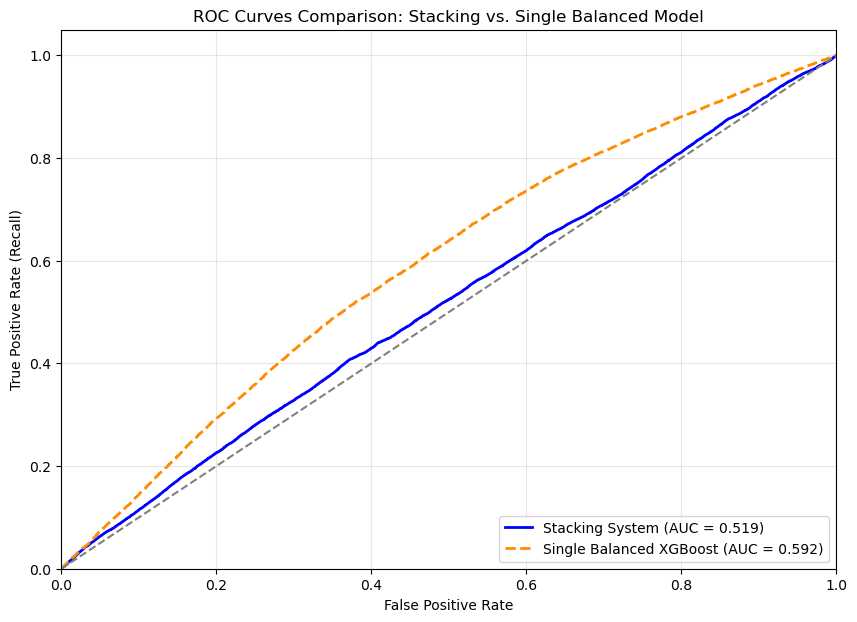

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ========================================================
# 1. تجهيز البيانات للرسم
# ========================================================

# أ) احتمالات نظام التجميع (Stacking) موجودة بالفعل في المتغير: y_proba

# ب) حساب احتمالات النظام الفردي (Single Balanced XGBoost) لرسم ROC
# نستخدم predict_proba بدلاً من predict
y_proba_single = single_pipeline.named_steps["xgb"].predict_proba(X_test_transformed)[:, 1]

# ج) تحديد التوقعات النهائية لنظام التجميع (عند العتبة 0.5 كمثال قياسي)
y_pred_stacking_05 = (y_proba >= 0.5).astype(int)

# ========================================================
# 2. رسم مصفوفات الالتباس (Side-by-Side Comparison)
# ========================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- المصفوفة الأولى: Stacking System ---
cm_stack = confusion_matrix(y_test, y_pred_stacking_05)
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix: Stacking (Stage 2) @ Thr=0.5')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# --- المصفوفة الثانية: Single Balanced XGBoost ---
# نستخدم y_pred_single المحسوبة مسبقاً في كودك
cm_single = confusion_matrix(y_test, y_pred_single)
sns.heatmap(cm_single, annot=True, fmt='d', cmap='Oranges', ax=axes[1], cbar=False)
axes[1].set_title('Confusion Matrix: Single Balanced XGBoost')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# ========================================================
# 3. رسم منحنيات ROC (Performance Comparison)
# ========================================================

plt.figure(figsize=(10, 7))

# --- منحنى نظام التجميع (Stacking) ---
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_proba)
auc_stack = auc(fpr_stack, tpr_stack)
plt.plot(fpr_stack, tpr_stack, linewidth=2, color='blue', label=f'Stacking System (AUC = {auc_stack:.3f})')

# --- منحنى النظام الفردي (Single Balanced) ---
fpr_single, tpr_single, _ = roc_curve(y_test, y_proba_single)
auc_single = auc(fpr_single, tpr_single)
plt.plot(fpr_single, tpr_single, linewidth=2, color='darkorange', linestyle='--', label=f'Single Balanced XGBoost (AUC = {auc_single:.3f})')

# --- إعدادات الرسم ---
plt.plot([0, 1], [0, 1], 'k--', color='gray') # خط العشوائية
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves Comparison: Stacking vs. Single Balanced Model')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

## Recall Sonucunun Aşırı Yükselmesi ve Modelin Anlamsal Çöküşü

Bu aşamada elde edilen sonuçlarda, pozitif sınıf (geçmişte ruhsal hastalık öyküsü bulunan bireyler) için **recall değerinin yaklaşık %99** seviyesine ulaştığı gözlemlenmiştir. İlk bakışta bu değer oldukça başarılı gibi görünse de, bu sonuç **modelin anlamlı bir sınıflandırma yapabildiğini göstermemektedir**.

Recall değerinin bu kadar yüksek olması, modelin neredeyse tüm örnekleri pozitif sınıfa atadığını göstermektedir. Bu durum, özellikle negatif sınıfa ait örneklerin (ruhsal hastalık öyküsü bulunmayan bireyler) büyük ölçüde yanlış şekilde pozitif olarak sınıflandırılmasıyla sonuçlanmıştır. Nitekim negatif sınıf için recall değerinin oldukça düşük olması, modelin ayırt edici gücünü kaybettiğini açıkça ortaya koymaktadır.

Bu sonuç, modelin **dengeyi sağlamak yerine tek bir sınıfa aşırı şekilde yöneldiğini** ve sınıflar arasındaki ayrımı fiilen ortadan kaldırdığını göstermektedir. Dolayısıyla model, yalnızca “hasta” etiketini üretme eğilimi gösteren bir yapı hâline gelmiş, gerçek bir sınıflandırıcı olma özelliğini yitirmiştir.

Bu nedenle elde edilen yüksek recall değeri, modelin başarısını değil; aksine **modelin anlamsal olarak çöktüğünü** ve veri üzerindeki ayırt edici bilgiyi etkin şekilde kullanamadığını göstermektedir. Böyle bir model, ne dengeli bir sınıflandırma sistemi olarak ne de güvenilir bir erken uyarı (screening) mekanizması olarak değerlendirilebilir.

Sonuç olarak bu deney, yüksek recall değerinin tek başına bir başarı ölçütü olmadığını ve özellikle dengesiz veri setlerinde model davranışının bütüncül metrikler ışığında değerlendirilmesi gerektiğini açıkça ortaya koymaktadır.


In [19]:
# =========================
# Balanced Model: XGBoost without SMOTE
# =========================

# Calculate class imbalance ratio from training data
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

xgb_balanced = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,   # imbalance handled internally
    eval_metric="logloss",
    random_state=42
)

# Pipeline WITHOUT SMOTE
balanced_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("xgb", xgb_balanced)
])

balanced_pipeline.fit(X_train, y_train)

print("Balanced XGBoost model trained successfully.")


Balanced XGBoost model trained successfully.


In [20]:
# =========================
# Evaluation of Balanced Model
# =========================

X_test_transformed = preprocessor.transform(X_test)
y_pred_balanced = balanced_pipeline.named_steps["xgb"].predict(X_test_transformed)

print("Recall:", recall_score(y_test, y_pred_balanced))
print("F1 Score:", f1_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))


Recall: 0.574090999403934
F1 Score: 0.4472616946843751
              precision    recall  f1-score   support

           0       0.75      0.57      0.65     57589
           1       0.37      0.57      0.45     25165

    accuracy                           0.57     82754
   macro avg       0.56      0.57      0.55     82754
weighted avg       0.64      0.57      0.59     82754



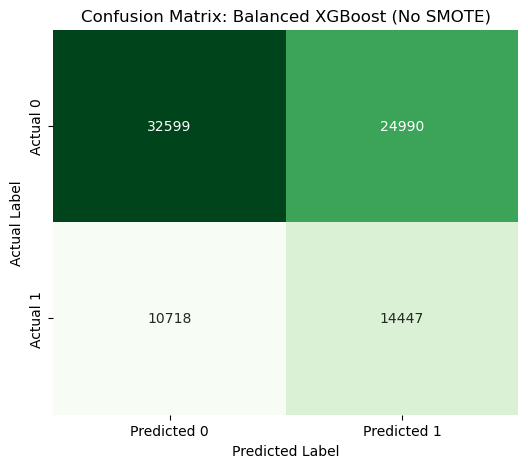

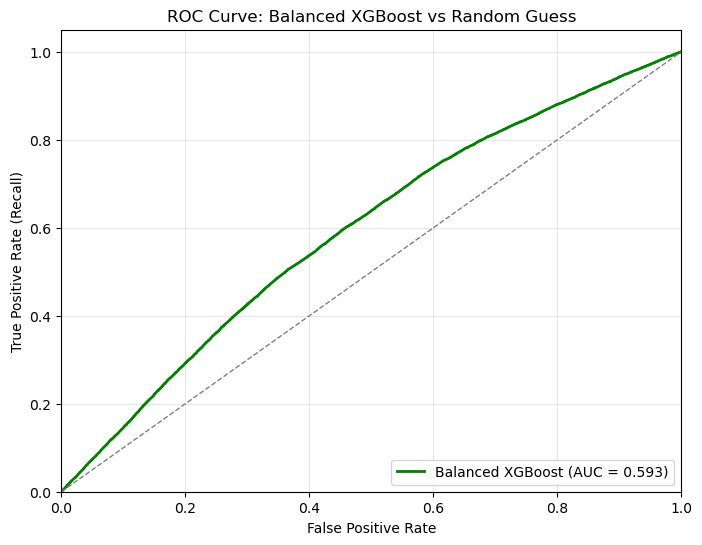

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ========================================================
# 1. تجهيز البيانات (حساب الاحتمالات)
# ========================================================

# نحتاج الاحتمالات (Probabilities) لرسم منحنى ROC بدقة
# نستخدم X_test_transformed الذي قمت بتجهيزه مسبقاً في كودك
y_proba_balanced = balanced_pipeline.named_steps["xgb"].predict_proba(X_test_transformed)[:, 1]

# ========================================================
# 2. رسم مصفوفة الالتباس (Confusion Matrix)
# ========================================================

plt.figure(figsize=(6, 5))

# حساب المصفوفة بناءً على التوقعات الموجودة لديك (y_pred_balanced)
cm = confusion_matrix(y_test, y_pred_balanced)

# الرسم باستخدام Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix: Balanced XGBoost (No SMOTE)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ========================================================
# 3. رسم منحنى ROC
# ========================================================

plt.figure(figsize=(8, 6))

# حساب الإحداثيات للمنحنى
fpr, tpr, _ = roc_curve(y_test, y_proba_balanced)
roc_auc = auc(fpr, tpr)

# الرسم
plt.plot(fpr, tpr, color='green', lw=2, label=f'Balanced XGBoost (AUC = {roc_auc:.3f})')

# الخط المرجعي (العشوائي)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# تنسيقات الرسم
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve: Balanced XGBoost vs Random Guess')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

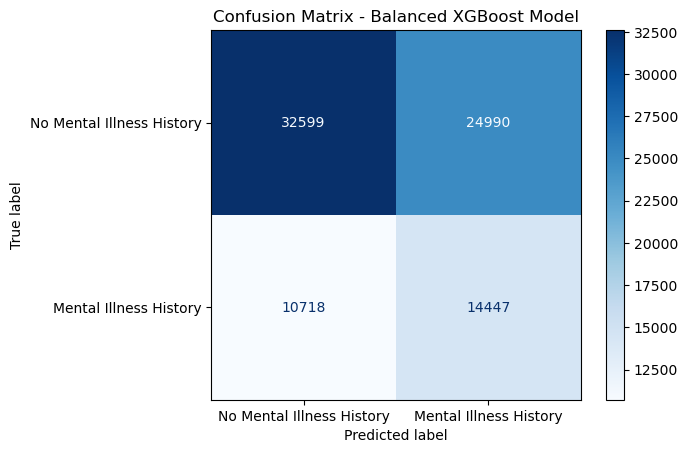

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_balanced)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Mental Illness History", "Mental Illness History"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Balanced XGBoost Model")
plt.show()


In [22]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

logreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("logreg", logreg)
])

logreg_pipeline.fit(X_train, y_train)

X_test_transformed = preprocessor.transform(X_test)
y_pred_logreg = logreg_pipeline.named_steps["logreg"].predict(X_test_transformed)

print("Logistic Regression Results")
print("Recall:", recall_score(y_test, y_pred_logreg))
print("F1:", f1_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Results
Recall: 0.6869461553745281
F1: 0.46783578252280045
              precision    recall  f1-score   support

           0       0.77      0.45      0.57     57589
           1       0.35      0.69      0.47     25165

    accuracy                           0.52     82754
   macro avg       0.56      0.57      0.52     82754
weighted avg       0.64      0.52      0.54     82754



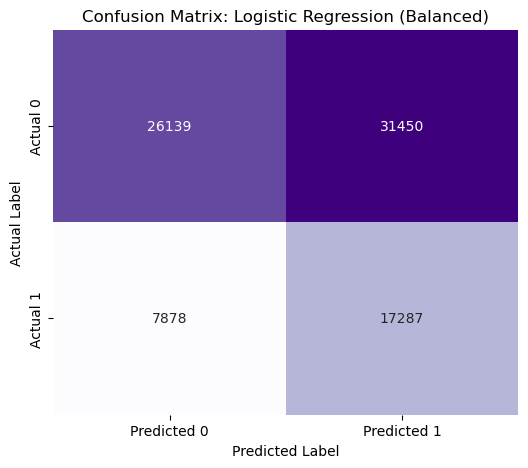

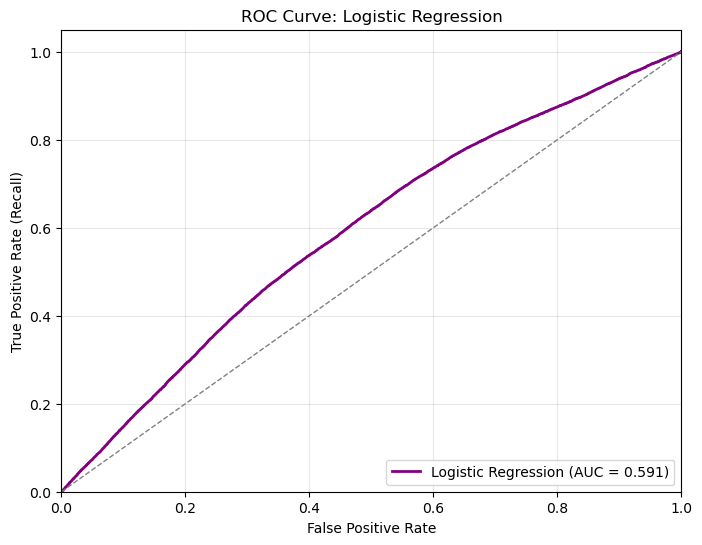

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ========================================================
# 1. تجهيز البيانات (حساب الاحتمالات)
# ========================================================

# نحتاج الاحتمالات (Probabilities) لرسم منحنى ROC
# نستخدم النموذج المدرب داخل الـ Pipeline مع البيانات المحولة مسبقاً
y_proba_log = logreg_pipeline.named_steps["logreg"].predict_proba(X_test_transformed)[:, 1]

# ========================================================
# 2. رسم مصفوفة الالتباس (Confusion Matrix)
# ========================================================

plt.figure(figsize=(6, 5))

# حساب المصفوفة بناءً على التوقعات الموجودة لديك
cm = confusion_matrix(y_test, y_pred_logreg)

# الرسم باستخدام Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix: Logistic Regression (Balanced)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ========================================================
# 3. رسم منحنى ROC
# ========================================================

plt.figure(figsize=(8, 6))

# حساب الإحداثيات للمنحنى
fpr, tpr, _ = roc_curve(y_test, y_proba_log)
roc_auc = auc(fpr, tpr)

# الرسم
plt.plot(fpr, tpr, color='purple', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.3f})')

# الخط المرجعي (العشوائي)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# تنسيقات الرسم
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve: Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Get feature importances from the trained XGBoost model
importances = balanced_pipeline.named_steps["xgb"].feature_importances_

# Create DataFrame
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display table
fi_df


,Feature,Importance
2,num__Income,0.883323
0,num__Age,0.085246
1,num__Number of Children,0.031431


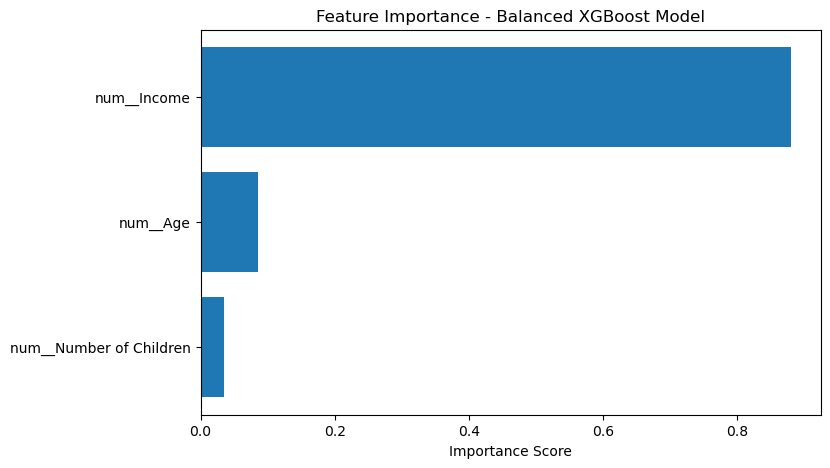

In [32]:
# Plot Feature Importance
plt.figure(figsize=(8, 5))
plt.barh(fi_df["Feature"], fi_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - Balanced XGBoost Model")
plt.xlabel("Importance Score")
plt.show()


## Sayfa Wisam – Modelleme Mantığı

Wisam sayfasında izlenen yaklaşımın temel amacı, veri setinin sunduğu bilginin herhangi bir yönlendirme veya yapay müdahale olmaksızın, sınıflandırma problemine ne ölçüde katkı sağlayabildiğini ortaya koymaktır. Bu kapsamda modelleme süreci, sentetik veri üretimi veya manuel eşik ayarlamaları gibi karar mekanizmasını doğrudan etkileyen yöntemlerden bilinçli olarak arındırılmıştır.

Model, sınıf dengesizliği sorununu yalnızca algoritmanın kendi iç mekanizmaları aracılığıyla ele almış ve gerçek veri dağılımı korunmuştur. Böylece amaç, modelin değil verinin sınırlarını gözlemlemek ve mevcut özelliklerin ruhsal hastalık geçmişini ne ölçüde temsil edebildiğini analiz etmektir.

Elde edilen sonuçlar, modelin dengeli fakat sınırlı bir performans sergilediğini ve karar sürecinin büyük ölçüde birkaç demografik değişkene dayandığını göstermiştir. Bu durum, başarının önündeki temel engelin algoritma seçimi değil, veri setinin ayırt edici bilgi kapasitesi olduğunu ortaya koymaktadır.


## Sayfa Mustafa – Modelleme Mantığı

Mustafa sayfasında izlenen yaklaşım, sınıflandırma problemini daha çok pozitif sınıfın yakalanması üzerine odaklanan yönlendirilmiş bir modelleme stratejisine dayanmaktadır. Bu kapsamda modelin karar eşiği manuel olarak ayarlanmış ve çok aşamalı (stage-based) bir yapı kullanılarak modelin pozitif örneklere karşı duyarlılığı artırılmıştır.

Bu yaklaşımda temel hedef, modelin pozitif sınıfı mümkün olduğunca kaçırmaması olup, bu doğrultuda precision–recall dengesi bilinçli olarak recall lehine bozulmuştur. Böylece modelin davranışı, doğal veri dağılımından ziyade belirlenen performans önceliklerine göre şekillendirilmiştir.

Bu noktada elde edilen model, rastgele veya anlamsız bir yapı sergilememektedir. Aksine, açık bir hedef doğrultusunda tasarlanmış, belirli bir karar stratejisini tutarlı biçimde uygulayan ve bu hedefi başarıyla gerçekleştiren bir modeldir. Modelin yüksek recall değerlerine ulaşması, karar mekanizmasının kontrolsüz değil; aksine bilinçli ve yönlendirilmiş bir şekilde yapılandırıldığını göstermektedir.

Ancak bu durum, modelin genel ve tarafsız bir sınıflandırıcı olduğu anlamına gelmemektedir. Model, pozitif sınıfı yakalama hedefi doğrultusunda şekillendirilmiş olup, doğal veri dağılımını yansıtan dengeli bir karar mekanizmasından ziyade, belirli bir senaryo için optimize edilmiş koşullu bir yapı sunmaktadır. Bu nedenle Mustafa sayfasında geliştirilen model, anlamsız veya çökmüş bir sistem değil; belirli bir amaca hizmet eden, ancak genellenebilirliği sınırlı olan “koşullu anlamlı” bir model olarak değerlendirilmelidir.


## Yaklaşımların Karşılaştırılması

Wisam ve Mustafa sayfalarında kullanılan yöntemler, aynı veri seti üzerinde farklı modelleme felsefelerini temsil etmektedir. Wisam sayfasında amaç, modelin yönlendirilmeden, verinin sunduğu bilgiyle ne ölçüde anlamlı bir ayrım yapabildiğini analiz etmek iken; Mustafa sayfasında model davranışı belirli bir hedef metrik doğrultusunda şekillendirilmiştir.

Bu bağlamda Mustafa sayfasında elde edilen sayısal başarılar, modelin duyarlılığının artırılmasının bir sonucu olarak ortaya çıkarken; Wisam sayfasında elde edilen daha sınırlı performans, veri setinin temsil gücüne dair daha doğrudan ve tarafsız bir değerlendirme sunmaktadır. Dolayısıyla iki yaklaşım birbirinin alternatifi değil, problemin farklı yönlerini ortaya koyan tamamlayıcı analizler olarak değerlendirilmektedir.



## Deep Learning Modelleri (PyTorch)

Bu bölümde, **Wisam'ın yığınlama (stacking) ve kolektif karar** felsefesine paralel olacak
şekilde PyTorch kullanılarak iki farklı **MLP (Multi-Layer Perceptron)** mimarisi
geliştirilmiştir. Amaç, çoklu doğrusal olmayan dönüşümler yoluyla karar sınırlarını
zenginleştirmek ve klasik ensemble sistemleriyle karşılaştırma yapmaktır.

> Not: Önceki bölümlerde kullanılan preprocessing adımları ve train/test split aynen korunmuştur.


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def finalize_and_encode_data(X_train, X_test, y_train, y_test):
    X_train_c = X_train.copy()
    X_test_c = X_test.copy()
    
    # 1. تحديد الأعمدة النصية
    cat_cols = X_train_c.select_dtypes(include=['object']).columns
    
    # 2. حذف أعمدة الأسماء أو المعرفات الشخصية (التي تحتوي على قيم فريدة كثيرة جداً)
    # هذا يمنع خطأ "could not convert string to float: 'Jenna Baker'"
    to_drop = [c for c in cat_cols if X_train_c[c].nunique() > (len(X_train_c) * 0.8)]
    X_train_c = X_train_c.drop(columns=to_drop)
    X_test_c = X_test_c.drop(columns=to_drop)
    
    # 3. تشفير الأعمدة النصية المتبقية (مثل نوع الوظيفة أو الحالة الاجتماعية)
    remaining_cat = X_train_c.select_dtypes(include=['object']).columns
    le = LabelEncoder()
    for col in remaining_cat:
        # دمج البيانات لضمان شمولية التشفير
        full = pd.concat([X_train_c[col], X_test_c[col]], axis=0).astype(str)
        le.fit(full)
        X_train_c[col] = le.transform(X_train_c[col].astype(str))
        X_test_c[col] = le.transform(X_test_c[col].astype(str))
    
    # 4. التحويل النهائي إلى مصفوفات NumPy بصيغة float32
    # هذا يحل مشكلة "could not determine the shape of object type 'DataFrame'"
    X_tr_final = X_train_c.values.astype(np.float32)
    X_ts_final = X_test_c.values.astype(np.float32)
    
    # التأكد من أن y مصفوفة رقمية بسيطة
    y_tr_final = y_train.values if hasattr(y_train, 'values') else np.array(y_train)
    y_ts_final = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
    
    print(f"✅ تم التجهيز: حُذف {len(to_drop)} أعمدة أسماء، وشُفر {len(remaining_cat)} أعمدة نصية.")
    return X_tr_final, X_ts_final, y_tr_final.astype(np.float32), y_ts_final.astype(np.float32)

# استدعاء الدالة لتحديث البيانات لديك
X_train, X_test, y_train, y_test = finalize_and_encode_data(X_train, X_test, y_train, y_test)

✅ تم التجهيز: حُذف 0 أعمدة أسماء، وشُفر 12 أعمدة نصية.


In [17]:

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np


In [18]:

# Utility functions
def to_tensor(x, y):
    X_t = torch.tensor(x, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    return X_t, y_t

def train_mlp(model, X_train_t, y_train_t, epochs=30, lr=1e-3, pos_weight=None):
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        logits = model(X_train_t)
        loss = criterion(logits, y_train_t)
        loss.backward()
        optimizer.step()
    return model

def eval_mlp(model, X_test_t, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(X_test_t)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        preds = (probs >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "auc": roc_auc_score(y_test, probs),
        "probs": probs
    }


In [19]:

# MLP Model 1: Deeper consensus-oriented
class StackingMLP_A(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# MLP Model 2: Wider architecture for richer representations
class StackingMLP_B(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x)


In [20]:

# === RUN DEEP LEARNING MODELS (Wisam) ===
# Assumes X_train, X_test, y_train, y_test already exist

X_train_t, y_train_t = to_tensor(X_train, y_train)
X_test_t, y_test_t = to_tensor(X_test, y_test)

input_dim = X_train.shape[1]

# Balanced loss to support ensemble-like stability
pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()], dtype=torch.float32)

# Train Model A
model_a = StackingMLP_A(input_dim)
model_a = train_mlp(model_a, X_train_t, y_train_t, epochs=30, lr=1e-3, pos_weight=pos_weight)
res_a = eval_mlp(model_a, X_test_t, y_test)

# Train Model B
model_b = StackingMLP_B(input_dim)
model_b = train_mlp(model_b, X_train_t, y_train_t, epochs=30, lr=8e-4, pos_weight=pos_weight)
res_b = eval_mlp(model_b, X_test_t, y_test)

res_a, res_b


({'accuracy': 0.5347052710443,
  'precision': 0.35651594028309597,
  'recall': 0.6585734154579773,
  'f1': 0.46260345284783183,
  'auc': 0.588321708511147,
  'probs': array([0.50429624, 0.48614213, 0.43441704, ..., 0.518935  , 0.5079208 ,
         0.5595579 ], dtype=float32)},
 {'accuracy': 0.5297749957705972,
  'precision': 0.35543638275499473,
  'recall': 0.6716073912179614,
  'f1': 0.46485594444062434,
  'auc': 0.5901076420947762,
  'probs': array([0.49155706, 0.48290208, 0.463197  , ..., 0.50904334, 0.49723458,
         0.5429832 ], dtype=float32)})

In [21]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def show_confusion_matrix(y_true, probs, threshold=0.5, model_name="Model"):
    """
    Displays confusion matrix as a clear table
    """
    preds = (probs >= threshold).astype(int)
    cm = confusion_matrix(y_true, preds)

    cm_df = pd.DataFrame(
        cm,
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"]
    )

    print(f"\n📊 Confusion Matrix – {model_name} (threshold={threshold})")
    print(cm_df)

    return cm_df


In [22]:
cm_a = show_confusion_matrix(
    y_test,
    res_a["probs"],
    threshold=0.5,
    model_name="StackingMLP_A"
)

cm_b = show_confusion_matrix(
    y_test,
    res_b["probs"],
    threshold=0.5,
    model_name="StackingMLP_B"
)



📊 Confusion Matrix – StackingMLP_A (threshold=0.5)
          Predicted 0  Predicted 1
Actual 0        27676        29913
Actual 1         8592        16573

📊 Confusion Matrix – StackingMLP_B (threshold=0.5)
          Predicted 0  Predicted 1
Actual 0        26940        30649
Actual 1         8264        16901


In [23]:
results_df = pd.DataFrame([
    {
        "Model": "StackingMLP_A",
        "Accuracy": res_a["accuracy"],
        "Precision": res_a["precision"],
        "Recall": res_a["recall"],
        "F1": res_a["f1"],
        "AUC": res_a["auc"]
    },
    {
        "Model": "StackingMLP_B",
        "Accuracy": res_b["accuracy"],
        "Precision": res_b["precision"],
        "Recall": res_b["recall"],
        "F1": res_b["f1"],
        "AUC": res_b["auc"]
    }
])

print("\n📈 Model Comparison Table")
print(results_df)



📈 Model Comparison Table
           Model  Accuracy  Precision    Recall        F1       AUC
0  StackingMLP_A  0.534705   0.356516  0.658573  0.462603  0.588322
1  StackingMLP_B  0.529775   0.355436  0.671607  0.464856  0.590108


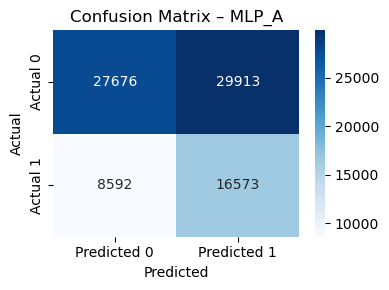

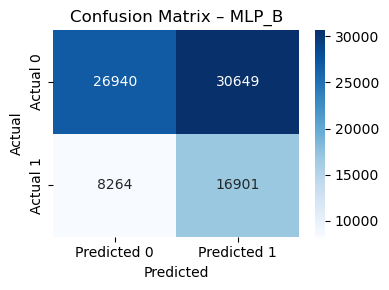

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm_df, title):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm_a, "Confusion Matrix – MLP_A")
plot_confusion_matrix(cm_b, "Confusion Matrix – MLP_B")


🔄 جاري تجهيز البيانات وتدريب نماذج Wisam...
⚠️ البيانات محولة مسبقاً (NumPy Array). سيتم استخدامها مباشرة.
✅ تم التدريب بنجاح!
📈 جاري رسم منحنيات ROC...


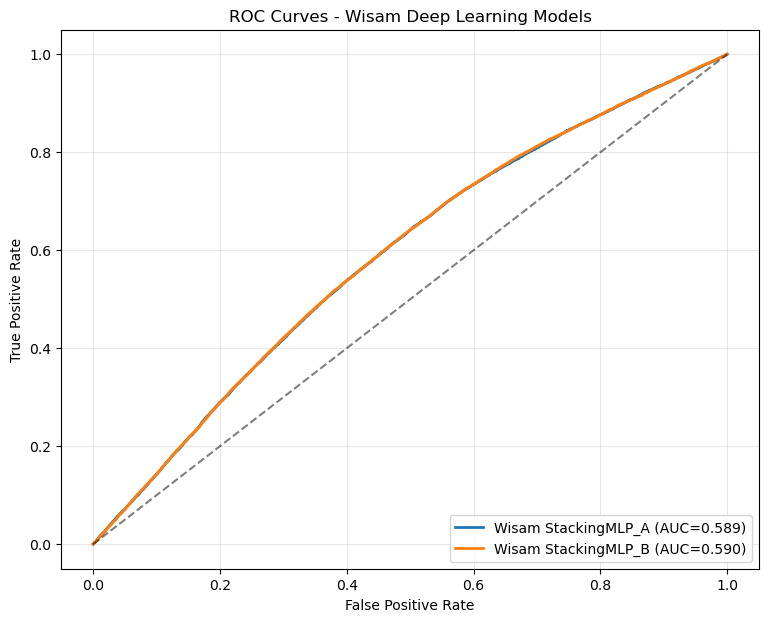


📊 Model Comparison Table
           Model  Accuracy    Recall        F1       AUC
0  StackingMLP_A  0.554269  0.611802  0.454978  0.589464
1  StackingMLP_B  0.537243  0.654202  0.462307  0.589958


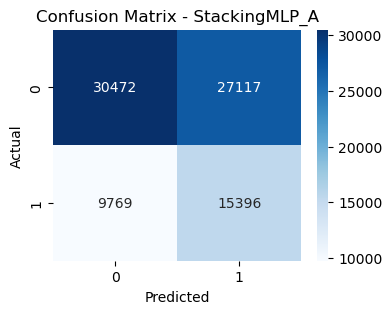

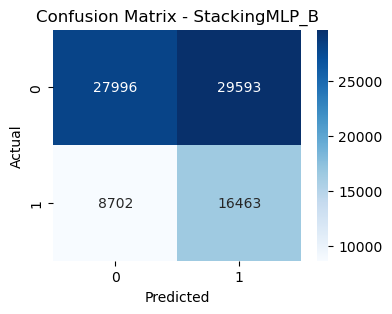

In [26]:
# ==========================================
# 1. التجهيز والتدريب (Wisam Deep Learning) - النسخة المصححة
# ==========================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

# --- دالة تجهيز البيانات (Data Preprocessing) ---
# تم تعديل هذه الدالة لتعالج الخطأ تلقائياً
def finalize_and_encode_data(X_train, X_test, y_train, y_test):
    # فحص ما إذا كانت البيانات مصفوفة NumPy بالفعل (تمت معالجتها سابقاً)
    if isinstance(X_train, np.ndarray):
        print("⚠️ البيانات محولة مسبقاً (NumPy Array). سيتم استخدامها مباشرة.")
        
        # التأكد من الأنواع
        X_tr_final = X_train.astype(np.float32)
        X_ts_final = X_test.astype(np.float32)
        
        # معالجة y حسب نوعها
        y_tr_final = y_train if isinstance(y_train, np.ndarray) else y_train.values
        y_ts_final = y_test if isinstance(y_test, np.ndarray) else y_test.values
        
        return X_tr_final, X_ts_final, y_tr_final.astype(np.float32), y_ts_final.astype(np.float32)

    # إذا كانت DataFrame (لم تعالج بعد)، نقوم بالمعالجة العادية
    X_train_c = X_train.copy()
    X_test_c = X_test.copy()
    
    # تحديد الأعمدة النصية
    cat_cols = X_train_c.select_dtypes(include=['object']).columns
    
    # حذف الأعمدة ذات القيم الفريدة الكثيرة (مثل الأسماء)
    to_drop = [c for c in cat_cols if X_train_c[c].nunique() > (len(X_train_c) * 0.8)]
    X_train_c = X_train_c.drop(columns=to_drop)
    X_test_c = X_test_c.drop(columns=to_drop)
    
    # تشفير الأعمدة النصية المتبقية
    remaining_cat = X_train_c.select_dtypes(include=['object']).columns
    le = LabelEncoder()
    for col in remaining_cat:
        full = pd.concat([X_train_c[col], X_test_c[col]], axis=0).astype(str)
        le.fit(full)
        X_train_c[col] = le.transform(X_train_c[col].astype(str))
        X_test_c[col] = le.transform(X_test_c[col].astype(str))
    
    # التحويل النهائي
    X_tr_final = X_train_c.values.astype(np.float32)
    X_ts_final = X_test_c.values.astype(np.float32)
    
    y_tr_final = y_train.values if hasattr(y_train, 'values') else np.array(y_train)
    y_ts_final = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
    
    print(f"✅ تم التجهيز: حُذف {len(to_drop)} أعمدة، وشُفر {len(remaining_cat)} أعمدة.")
    return X_tr_final, X_ts_final, y_tr_final.astype(np.float32), y_ts_final.astype(np.float32)

# --- دوال المساعدة للشبكات العصبية ---
def to_tensor(x, y):
    X_t = torch.tensor(x, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    return X_t, y_t

def train_mlp(model, X_train_t, y_train_t, epochs=30, lr=1e-3, pos_weight=None):
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        logits = model(X_train_t)
        loss = criterion(logits, y_train_t)
        loss.backward()
        optimizer.step()
    return model

def eval_mlp(model, X_test_t, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(X_test_t)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        preds = (probs >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "auc": roc_auc_score(y_test, probs),
        "probs": probs
    }

# --- تعريف النماذج (Wisam Models) ---
class StackingMLP_A(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

class StackingMLP_B(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.4), nn.Linear(128, 1)
        )
    def forward(self, x): return self.net(x)

# --- التنفيذ (Execution) ---
print("🔄 جاري تجهيز البيانات وتدريب نماذج Wisam...")

# 1. تحديث البيانات باستخدام دالة المعالجة (المعدلة لتفادي الخطأ)
X_train_final, X_test_final, y_train_final, y_test_final = finalize_and_encode_data(X_train, X_test, y_train, y_test)

# 2. التحويل لـ Tensors
X_train_t, y_train_t = to_tensor(X_train_final, y_train_final)
X_test_t, y_test_t = to_tensor(X_test_final, y_test_final)

input_dim = X_train_final.shape[1]
pos_weight = torch.tensor([(len(y_train_final) - y_train_final.sum()) / y_train_final.sum()], dtype=torch.float32)

# 3. تدريب النموذج A
model_a = StackingMLP_A(input_dim)
model_a = train_mlp(model_a, X_train_t, y_train_t, epochs=30, lr=1e-3, pos_weight=pos_weight)
res_a = eval_mlp(model_a, X_test_t, y_test_final)

# 4. تدريب النموذج B
model_b = StackingMLP_B(input_dim)
model_b = train_mlp(model_b, X_train_t, y_train_t, epochs=30, lr=8e-4, pos_weight=pos_weight)
res_b = eval_mlp(model_b, X_test_t, y_test_final)

print("✅ تم التدريب بنجاح!")

# ==========================================
# 2. رسم منحنيات ROC (ROC Plotting Section)
# ==========================================
print("📈 جاري رسم منحنيات ROC...")

candidates = {
    "Wisam StackingMLP_A": res_a['probs'],
    "Wisam StackingMLP_B": res_b['probs']
}

plt.figure(figsize=(9, 7))
for name, probs in candidates.items():
    fpr, tpr, _ = roc_curve(y_test_final, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Wisam Deep Learning Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 3. عرض النتائج وجدول المقارنة
# ==========================================
results_df = pd.DataFrame([
    {"Model": "StackingMLP_A", "Accuracy": res_a["accuracy"], "Recall": res_a["recall"], "F1": res_a["f1"], "AUC": res_a["auc"]},
    {"Model": "StackingMLP_B", "Accuracy": res_b["accuracy"], "Recall": res_b["recall"], "F1": res_b["f1"], "AUC": res_b["auc"]}
])
print("\n📊 Model Comparison Table")
print(results_df)

# عرض Confusion Matrix بشكل مرئي
def plot_cm(y_true, probs, title):
    preds = (probs >= 0.5).astype(int)
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

plot_cm(y_test_final, res_a["probs"], "Confusion Matrix - StackingMLP_A")
plot_cm(y_test_final, res_b["probs"], "Confusion Matrix - StackingMLP_B")